In [13]:
!pip install scikeras

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from google.colab import drive
drive.mount('/content/drive')
import pickle



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.head(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-12-05,147.770004,150.919998,145.770004,146.630005,145.814972,68826400,APPLE
2022-12-06,147.070007,147.300003,141.919998,142.910004,142.115646,64727200,APPLE
2022-12-07,142.190002,143.369995,140.000000,140.940002,140.156586,69721100,APPLE
2022-12-08,142.360001,143.520004,141.100006,142.649994,141.857086,62128300,APPLE
2022-12-09,142.339996,145.570007,140.899994,142.160004,141.369812,76097000,APPLE
2022-12-12,142.699997,144.500000,141.059998,144.490005,143.686859,70462700,APPLE
2022-12-13,149.500000,149.970001,144.240005,145.470001,144.661423,93886200,APPLE
2022-12-14,145.350006,146.660004,141.160004,143.210007,142.413986,82291200,APPLE
2022-12-15,141.110001,141.800003,136.029999,136.500000,135.741272,98931900,APPLE


In [15]:
aapl_df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
aapl_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449692,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655556,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787854,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767569,394024400
...,...,...,...,...,...,...
2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600
2023-11-28,189.779999,191.080002,189.399994,190.399994,190.399994,38415400
2023-11-29,190.899994,192.089996,188.970001,189.369995,189.369995,43014200


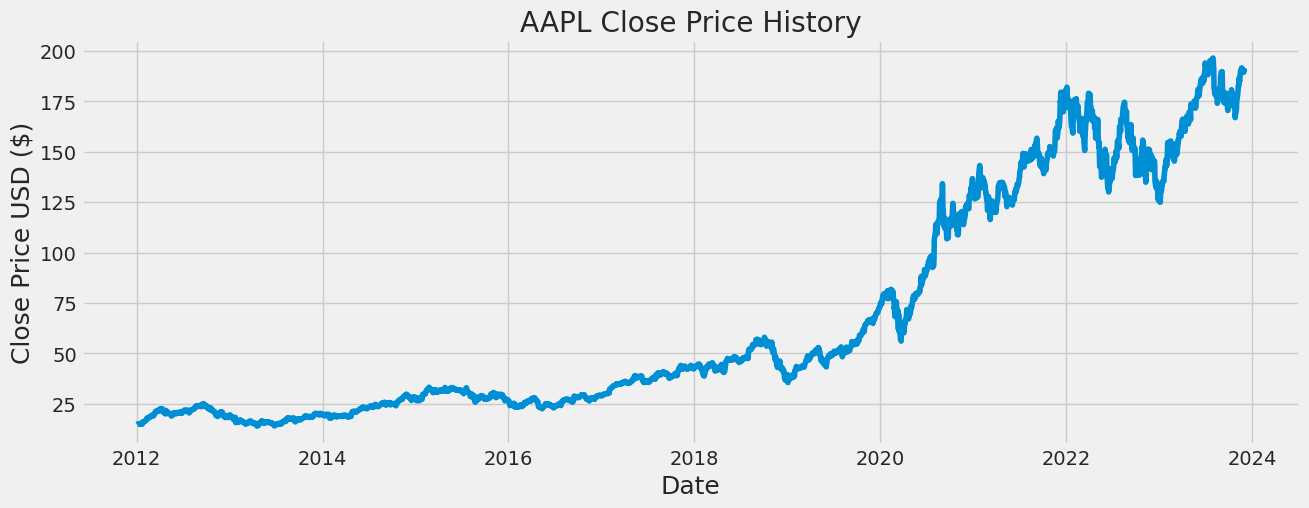

In [16]:
#AAPL Close price history
plt.figure(figsize=(14,5))
plt.title('AAPL Close Price History')
plt.plot(aapl_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [17]:
# Create a new dataframe with only the 'Close column
aapl_data = aapl_df.filter(['Close'])
# Convert the dataframe to a numpy array
aapl_dataset = aapl_data.values
# Get the number of rows to train the model on
aapl_training_data_len = int(np.ceil( len(aapl_dataset) * .95 ))

#training_data_len

In [18]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_scaled_data = scaler.fit_transform(aapl_dataset)

#scaled_data

In [19]:
# Create the training data set
# Create the scaled training data set
aapl_train_data = aapl_scaled_data[0:int(aapl_training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(aapl_train_data)):
    x_train.append(aapl_train_data[i-60:i, 0])
    y_train.append(aapl_train_data[i, 0])
    if i<= 61:
        #print(x_train)
        #print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Function to create sequences with a given interval
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

# Set the interval (30 days)
interval = 30

# Create sequences with the specified interval
x_train, y_train = create_sequences(aapl_train_data, interval)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2820/2820 [==============================] - 86s 29ms/step - loss: 9.9971e-04


In [21]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
aapl_test_data = aapl_scaled_data[aapl_training_data_len - interval: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = aapl_dataset[aapl_training_data_len:, :]
for i in range(interval, len(aapl_test_data)):
    x_test.append(aapl_test_data[i-interval:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 17ms/step


6.298128729302409

<ipython-input-22-2b95eb57cfe3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


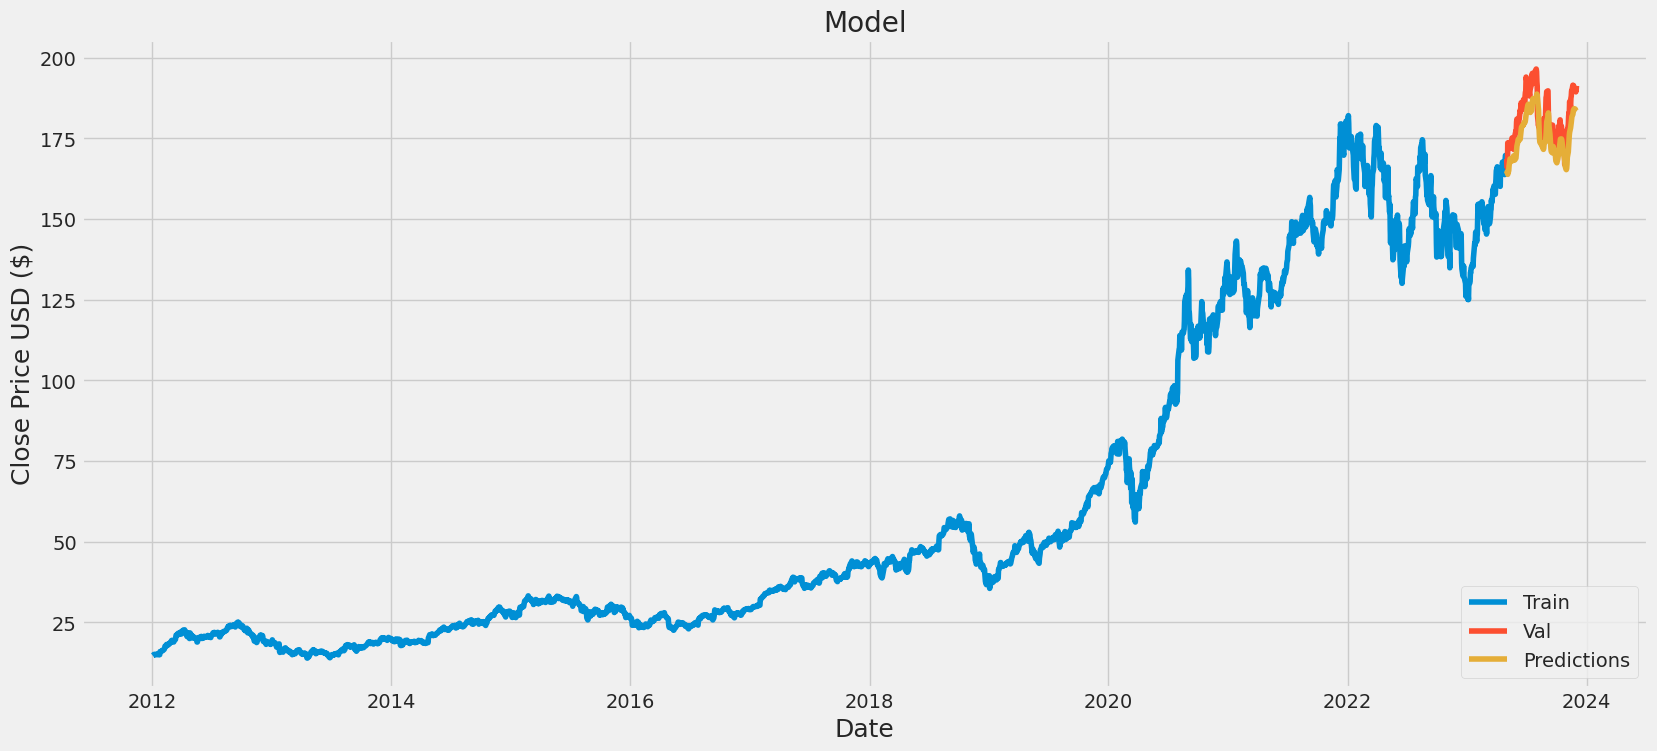

In [22]:
# Plot the data
train = aapl_data[:aapl_training_data_len]
valid = aapl_data[aapl_training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
# Function to create model, required for KerasRegressor
def create_model_grid(optimizer='adam'):
    model_grid = Sequential()
    model_grid.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model_grid.add(LSTM(64, return_sequences=False, activation='tanh'))
    model_grid.add(Dense(25, activation='tanh'))
    model_grid.add(Dense(1))
    model_grid.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_grid

# Create the model
model_grid = KerasRegressor(build_fn=create_model_grid, verbose=0)

# Define the grid search parameters
optimizer = [ 'RMSprop', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)

# Create Grid Search
grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.9187442118702872 using {'optimizer': 'Adagrad'}
Means: 0.9134173869110962, Stdev: 0.054635584137410376 with: {'optimizer': 'RMSprop'}
Means: 0.9187442118702872, Stdev: 0.05272524504994748 with: {'optimizer': 'Adagrad'}
Means: 0.8999513176343215, Stdev: 0.07608164690246308 with: {'optimizer': 'Adam'}


In [24]:
with open('/content/drive/My Drive/aapl_best_grid_model.pkl', 'wb') as f:
    pickle.dump(grid_result, f)

In [25]:
goog_df = pdr.get_data_yahoo('GOOG', start='2012-01-01', end=datetime.now())
goog_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2023-11-27,137.570007,139.630005,137.539993,138.050003,138.050003,17886400
2023-11-28,137.630005,138.660004,137.039993,138.619995,138.619995,17046900
2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700


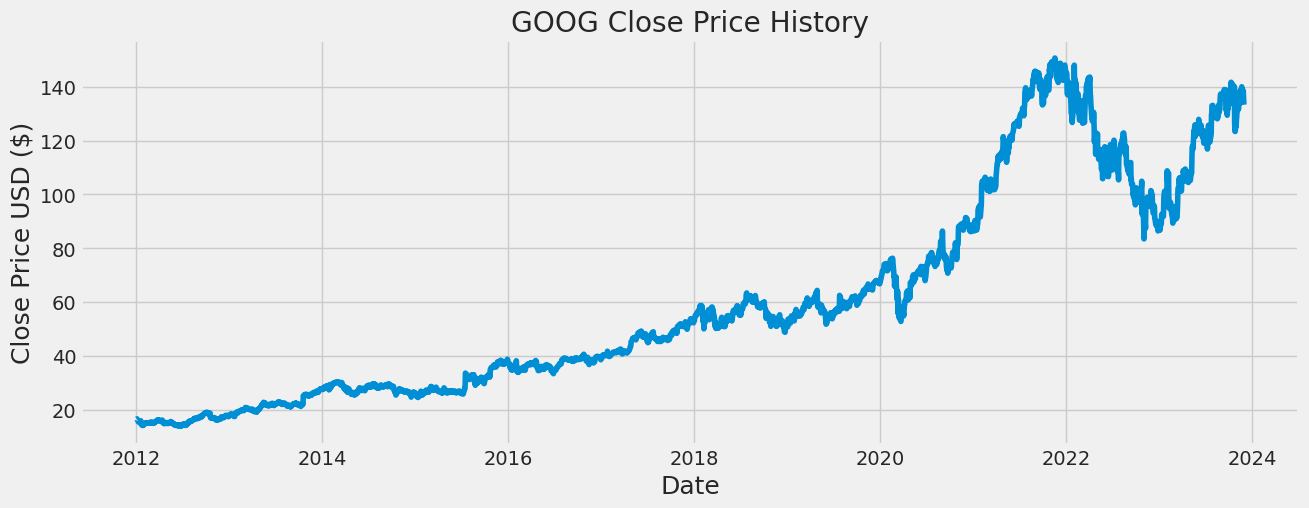

In [26]:
#GOOG Close price history
plt.figure(figsize=(14,5))
plt.title('GOOG Close Price History')
plt.plot(goog_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [27]:
# Create a new dataframe with only the 'Close column
goog_data = goog_df.filter(['Close'])
# Convert the dataframe to a numpy array
goog_dataset = goog_data.values
# Get the number of rows to train the model on
goog_training_data_len = int(np.ceil( len(goog_dataset) * .95 ))

#training_data_len

In [28]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
goog_scaled_data = scaler.fit_transform(goog_dataset)

#scaled_data

In [29]:
# Create the training data set
# Create the scaled training data set
goog_train_data = goog_scaled_data[0:int(goog_training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(goog_train_data)):
    x_train.append(goog_train_data[i-60:i, 0])
    y_train.append(goog_train_data[i, 0])
    if i<= 61:
        #print(x_train)
        #print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Function to create sequences with a given interval
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

# Set the interval (30 days)
interval = 30

# Create sequences with the specified interval
x_train, y_train = create_sequences(goog_train_data, interval)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2820/2820 [==============================] - 89s 30ms/step - loss: 0.0011


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
goog_test_data = goog_scaled_data[goog_training_data_len - interval: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = goog_dataset[goog_training_data_len:, :]
for i in range(interval, len(goog_test_data)):
    x_test.append(goog_test_data[i-interval:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# Plot the data
train = goog_data[:goog_training_data_len]
valid = goog_data[goog_training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Function to create model, required for KerasRegressor
def create_model_grid(optimizer='adam'):
    model_grid = Sequential()
    model_grid.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model_grid.add(LSTM(64, return_sequences=False, activation='tanh'))
    model_grid.add(Dense(25, activation='tanh'))
    model_grid.add(Dense(1))
    model_grid.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_grid

# Create the model
model_grid = KerasRegressor(build_fn=create_model_grid, verbose=0)

# Define the grid search parameters
optimizer = [ 'RMSprop', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)

# Create Grid Search
grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")


In [ ]:
with open('/content/drive/My Drive/goog_best_grid_model.pkl', 'wb') as f:
    pickle.dump(grid_result, f)

In [ ]:
msft_df = pdr.get_data_yahoo('MSFT', start='2012-01-01', end=datetime.now())
msft_df

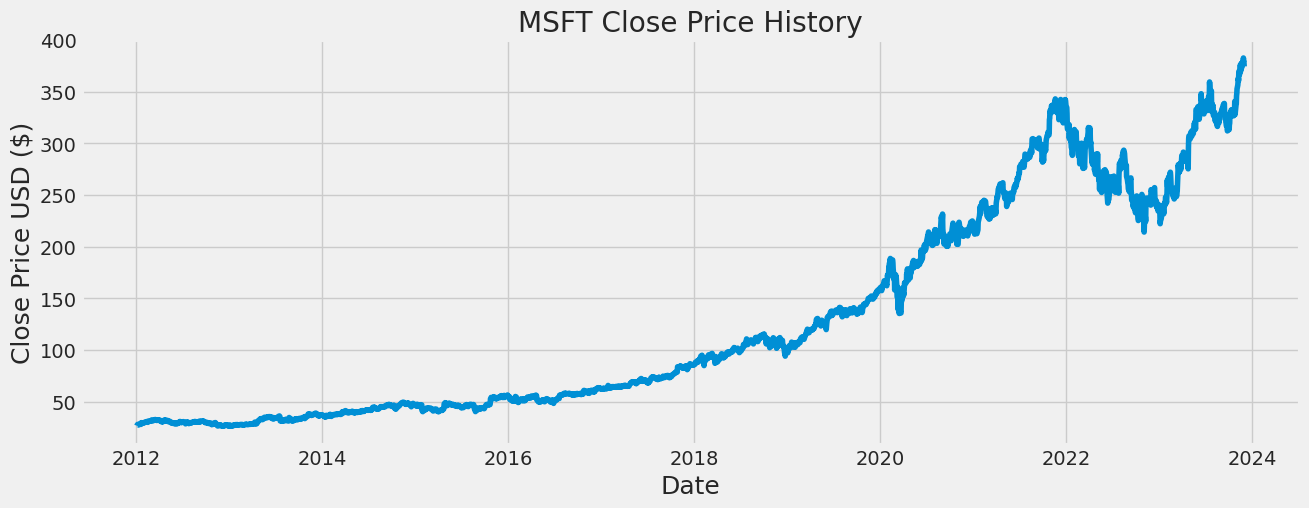

In [58]:
#MSFT Close price history
plt.figure(figsize=(14,5))
plt.title('MSFT Close Price History')
plt.plot(msft_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [59]:
# Create a new dataframe with only the 'Close column
msft_data = msft_df.filter(['Close'])
# Convert the dataframe to a numpy array
msft_dataset = msft_data.values
# Get the number of rows to train the model on
msft_training_data_len = int(np.ceil( len(msft_dataset) * .95 ))

#training_data_len

In [38]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
msft_scaled_data = scaler.fit_transform(msft_dataset)

#scaled_data

In [ ]:
# Create the training data set
# Create the scaled training data set
msft_train_data = msft_scaled_data[0:int(msft_training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(msft_train_data)):
    x_train.append(msft_train_data[i-60:i, 0])
    y_train.append(msft_train_data[i, 0])
    if i<= 61:
        #print(x_train)
        #print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Function to create sequences with a given interval
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

# Set the interval (30 days)
interval = 30

# Create sequences with the specified interval
x_train, y_train = create_sequences(msft_train_data, interval)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
msft_test_data = msft_scaled_data[msft_training_data_len - interval: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = msft_dataset[msft_training_data_len:, :]
for i in range(interval, len(msft_test_data)):
    x_test.append(msft_test_data[i-interval:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

<ipython-input-42-d1309123a208>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


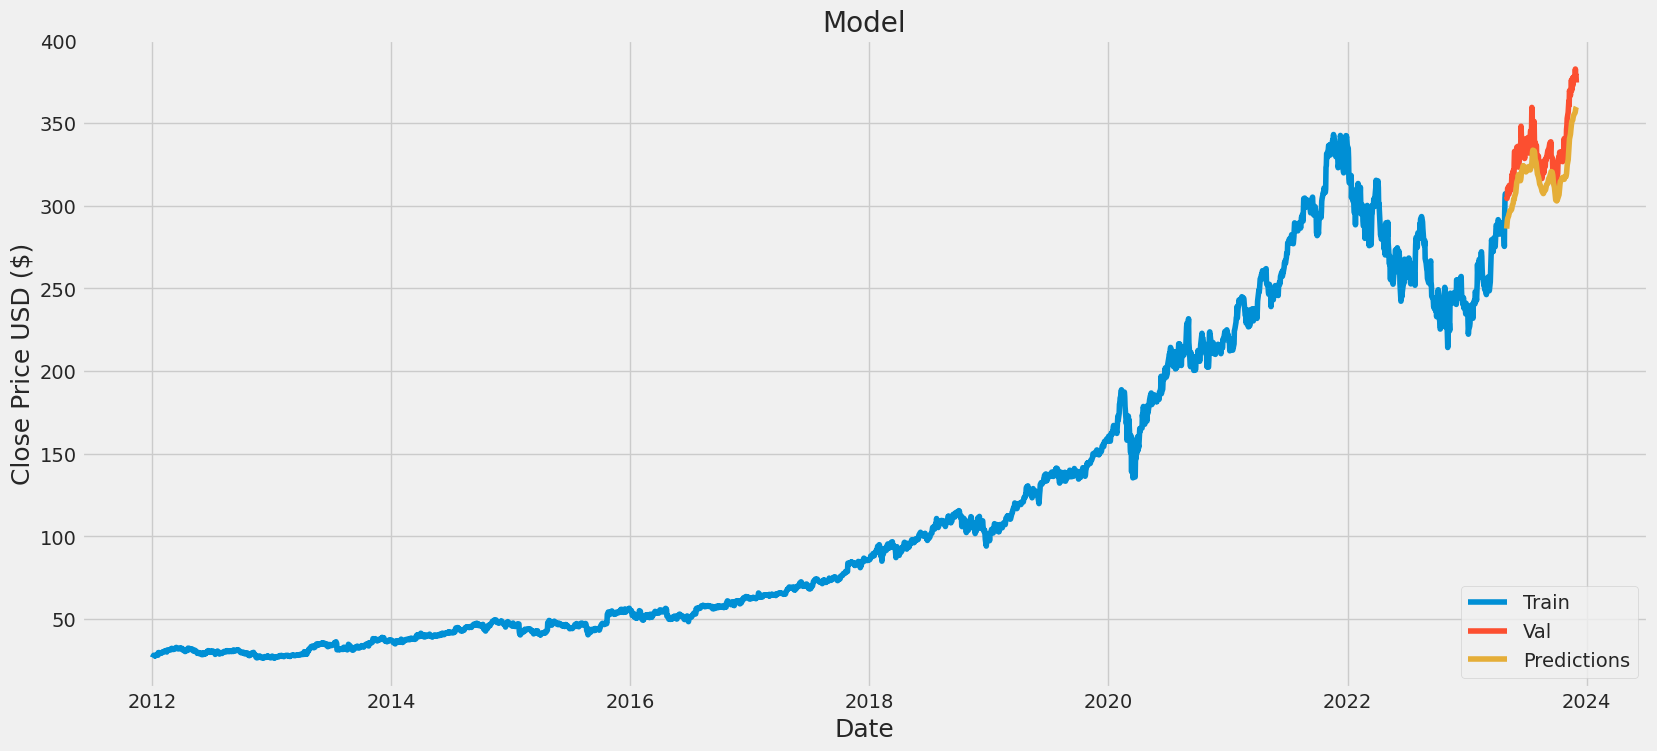

In [42]:
# Plot the data
train = msft_data[:msft_training_data_len]
valid = msft_data[msft_training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Function to create model, required for KerasRegressor
def create_model_grid(optimizer='adam'):
    model_grid = Sequential()
    model_grid.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model_grid.add(LSTM(64, return_sequences=False, activation='tanh'))
    model_grid.add(Dense(25, activation='tanh'))
    model_grid.add(Dense(1))
    model_grid.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_grid

# Create the model
model_grid = KerasRegressor(build_fn=create_model_grid, verbose=0)

# Define the grid search parameters
optimizer = [ 'RMSprop', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)

# Create Grid Search
grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")


In [ ]:
with open('/content/drive/My Drive/msft_best_grid_model.pkl', 'wb') as f:
    pickle.dump(grid_result, f)

In [ ]:
amzn_df = pdr.get_data_yahoo('AMZN', start='2012-01-01', end=datetime.now())
amzn_df

In [ ]:
#AMZN Close price history
plt.figure(figsize=(14,5))
plt.title('AMZN Close Price History')
plt.plot(amzn_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
amzn_data = amzn_df.filter(['Close'])
# Convert the dataframe to a numpy array
amzn_dataset = amzn_data.values
# Get the number of rows to train the model on
amzn_training_data_len = int(np.ceil( len(amzn_dataset) * .95 ))

#training_data_len

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
amzn_scaled_data = scaler.fit_transform(amzn_dataset)

#scaled_data

In [ ]:
# Create the training data set
# Create the scaled training data set
amzn_train_data = amzn_scaled_data[0:int(amzn_training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(amzn_train_data)):
    x_train.append(amzn_train_data[i-60:i, 0])
    y_train.append(amzn_train_data[i, 0])
    if i<= 61:
        #print(x_train)
        #print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Function to create sequences with a given interval
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

# Set the interval (30 days)
interval = 30

# Create sequences with the specified interval
x_train, y_train = create_sequences(amzn_train_data, interval)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [57]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2820/2820 [==============================] - 91s 31ms/step - loss: 0.0014


In [56]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
amzn_test_data = amzn_scaled_data[amzn_training_data_len - interval: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = amzn_dataset[amzn_training_data_len:, :]
for i in range(interval, len(amzn_test_data)):
    x_test.append(amzn_test_data[i-interval:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 19ms/step


3.37556702403189

<ipython-input-55-d93452e1edd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


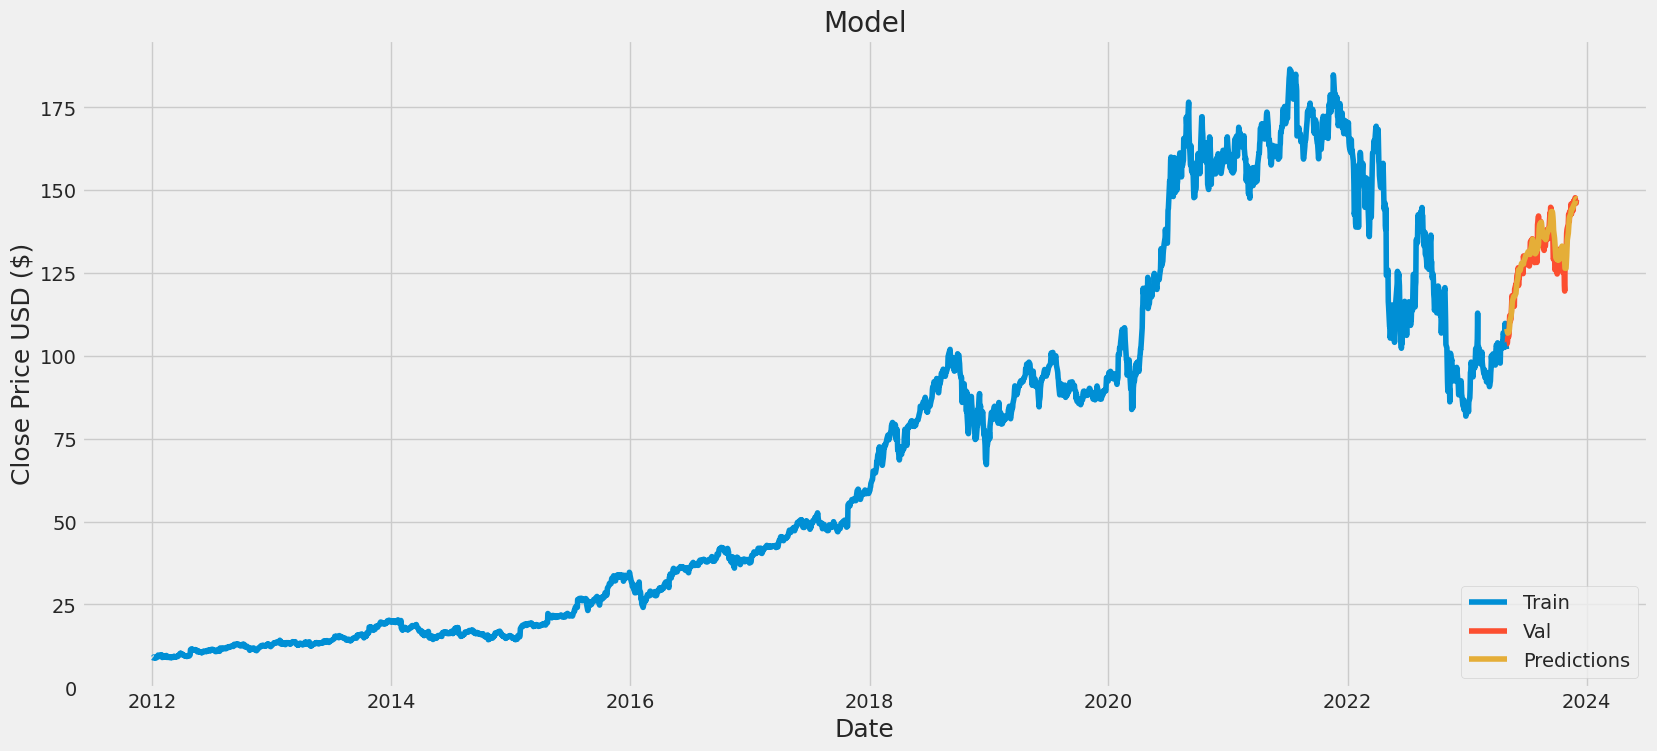

In [55]:
# Plot the data
train = amzn_data[:amzn_training_data_len]
valid = amzn_data[amzn_training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Function to create model, required for KerasRegressor
def create_model_grid(optimizer='adam'):
    model_grid = Sequential()
    model_grid.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model_grid.add(LSTM(64, return_sequences=False, activation='tanh'))
    model_grid.add(Dense(25, activation='tanh'))
    model_grid.add(Dense(1))
    model_grid.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_grid

# Create the model
model_grid = KerasRegressor(build_fn=create_model_grid, verbose=0)

# Define the grid search parameters
optimizer = [ 'RMSprop', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)

# Create Grid Search
grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")



In [ ]:
with open('/content/drive/My Drive/amzn_best_grid_model.pkl', 'wb') as f:
    pickle.dump(grid_result, f)